In [1]:
import numpy as np
from scipy.sparse import rand as sprand
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from itertools import product
import networkx as nx
from src.mf import negative_sample_bipartite

seed = 1234
rng = np.random.default_rng(seed=seed) # Seed random number generator

def cart_prod(row_idxs, col_idxs):
    return [np.array(elt) for elt in zip(*product(row_idxs, col_idxs))]

In [2]:
# Params

n_users = 1_00
n_items = 1_00
n_epochs = 5000
bs = 1 # Batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
density = 0.01
unobs_multiple = 1 # How many negative samples per

k = 2
train_split = 0.8


In [3]:
# Generate adjacency matrix

adj_type = 'knn' # random netflix knn

if adj_type == 'lattice':
    lattice2d = nx.grid_2d_graph(np.sqrt(n_users).astype(int), np.sqrt(n_items).astype(int))
    ratings = nx.adjacency_matrix(lattice2d)
    ratings = ratings.toarray()
    obs_pairs = list(zip(*ratings.nonzero()))

elif adj_type == 'knn':
    obs_pairs = []
    for i in range(n_users):
        for j in range(max(0, i - k), min(i + k, n_items)):
            obs_pairs.append((i, j))

    ratings = np.zeros(shape=(n_users, n_items))
    nz_rows, nz_cols = [np.array(elt) for elt in list(zip(*obs_pairs))]
    ratings[nz_rows, nz_cols] = 1

elif adj_type == 'random':
    n_obs = int(n_users * n_items * density)
    obs_rows = rng.integers(0, n_users, size=(n_obs,))
    obs_cols = rng.integers(0, n_items, size=(n_obs,))
    obs_pairs = list(zip(obs_rows, obs_cols))
    ratings = np.zeros(shape=(n_users, n_items))
    ratings[obs_rows, obs_cols] = 1

# Train test split observed positives
last_obs_idx = int(len(obs_pairs) * train_split)
obs_pairs = rng.permutation(obs_pairs)
obs_pairs_train, obs_pairs_test = obs_pairs[:last_obs_idx], obs_pairs[last_obs_idx:]
obs_rows_train, obs_cols_train = torch.LongTensor(obs_pairs_train[:,0]), torch.LongTensor(obs_pairs_train[:,1])
test_data = np.array(obs_pairs_test).astype(int)
test_target = torch.FloatTensor(ratings[test_data[:,0], test_data[:,1]]).reshape(test_data.shape[0], 1)
test_row, test_col = [torch.LongTensor(elt, device=device) for elt in (test_data[:,0], test_data[:,1])]

# Must be list of tuples for negative sampling
obs_pairs_train = [tuple(elt) for elt in obs_pairs_train]
obs_pairs = [tuple(elt) for elt in obs_pairs]

# Negative sampling
n_unobs = int(len(obs_pairs_train) * unobs_multiple)
unobs_pairs = negative_sample_bipartite(n_unobs, n_users, n_items, obs_pairs_train, seed=1234)
train_data = np.vstack((np.array(obs_pairs_train), np.array(unobs_pairs).reshape(-1, 2))).astype(int)

In [19]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=False)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=False)
        # self.user_biases = torch.nn.Embedding(n_users, 1, sparse=False)
        # self.item_biases = torch.nn.Embedding(n_items, 1, sparse=False)

        # self.user_factors.weight = self.scale_embed(self.user_factors.weight)
        # self.item_factors.weight = self.scale_embed(self.item_factors.weight)

        # torch.nn.init.normal_(self.user_biases.weight, mean=0, std=3e-1)
        # torch.nn.init.normal_(self.item_biases.weight, mean=0, std=1e-1)
        # torch.nn.init.normal_(self.user_factors.weight, mean=0, std=1e-1)
        # torch.nn.init.normal_(self.item_factors.weight, mean=0, std=1e-1)

    def forward(self, user, item):
        pred = (self.user_factors(user) * self.item_factors(item)).sum(dim=1, keepdim=True) # + self.user_biases(user) + self.item_biases(item)
        # return pred
        return torch.sigmoid(pred)
    
    def scale_embed(self, embedding):
        np_embed = embedding.detach().numpy()
        np_embed /= np.linalg.norm(np_embed, axis=1).reshape(-1,1)
        return torch.nn.Parameter(torch.FloatTensor(np_embed))
    
model = MatrixFactorization(n_users, n_items, n_factors=10).to(device)

# loss_func = torch.nn.MSELoss()
loss_func = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=1e-3)  # learning rate

In [20]:
all_users, all_items = [torch.LongTensor(elt) for elt in cart_prod(np.arange(n_users), np.arange(n_items))]
prior_beliefs = model(all_users, all_items).detach().numpy().reshape(n_users, n_items)


In [213]:
# Train

loss_curve = []
test_loss_curve = []
for ep in range(n_epochs):

    # Batch train data
    dl = DataLoader(train_data, batch_size=bs, shuffle=True)
    epoch_loss = []
    test_epoch_loss = []
    for i, batch in enumerate(dl):
        # Set gradients to zero
        optimizer.zero_grad()
        batch = batch.to(device)
        row, col = batch[:,0], batch[:,1]

        target = ratings[row, col].reshape(bs, 1)

        target = torch.FloatTensor(target, device=device)
        
        # Predict and calculate loss
        prediction = model(row, col)
        loss = loss_func(prediction, target)
        test_prediction = model(test_row, test_col)
        test_loss = loss_func(test_prediction, test_target)

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

        epoch_loss.append(loss.item())
        test_epoch_loss.append(test_loss.item())

    epoch_loss = np.array(epoch_loss)
    test_epoch_loss = np.array(test_epoch_loss)
    loss_curve.append((epoch_loss.mean(), epoch_loss.std()))
    test_loss_curve.append((test_epoch_loss.mean(), test_epoch_loss.std()))
    print(f"Epoch: {ep}. Train loss: {loss_curve[-1][0]}, Test loss: {test_loss_curve[-1][0]}")

Epoch: 0. Train loss: 1.2709540859826558, Test loss: 1.637207958328573
Epoch: 1. Train loss: 1.2247941262019457, Test loss: 1.6167488035899173
Epoch: 2. Train loss: 1.180844963469064, Test loss: 1.598347012755237
Epoch: 3. Train loss: 1.1385247293583234, Test loss: 1.5808595432133614
Epoch: 4. Train loss: 1.0980226332356993, Test loss: 1.5630324997856646
Epoch: 5. Train loss: 1.059524282482845, Test loss: 1.5462633126144167
Epoch: 6. Train loss: 1.0227360774667626, Test loss: 1.5293786401235605
Epoch: 7. Train loss: 0.9876599647845691, Test loss: 1.5153752716281745
Epoch: 8. Train loss: 0.95426945274377, Test loss: 1.4998401969294004
Epoch: 9. Train loss: 0.9224204985066996, Test loss: 1.4860228109586089
Epoch: 10. Train loss: 0.8920523740067506, Test loss: 1.4718273412200469
Epoch: 11. Train loss: 0.8633139662264557, Test loss: 1.457831967480575
Epoch: 12. Train loss: 0.8355190930549817, Test loss: 1.4464735986688468
Epoch: 13. Train loss: 0.8092152838148017, Test loss: 1.432772740155

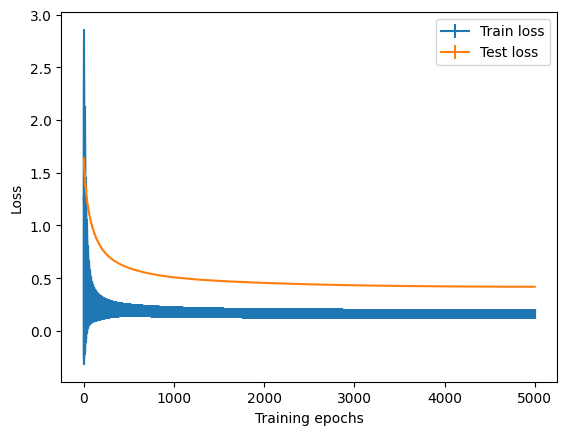

In [214]:
ave_loss, std_loss = list(zip(*loss_curve))

plt.errorbar(x=np.arange(n_epochs), y=ave_loss, yerr=std_loss, label="Train loss")
ave_loss, std_loss = list(zip(*test_loss_curve))
plt.errorbar(x=np.arange(n_epochs), y=ave_loss, yerr=std_loss, label="Test loss")
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

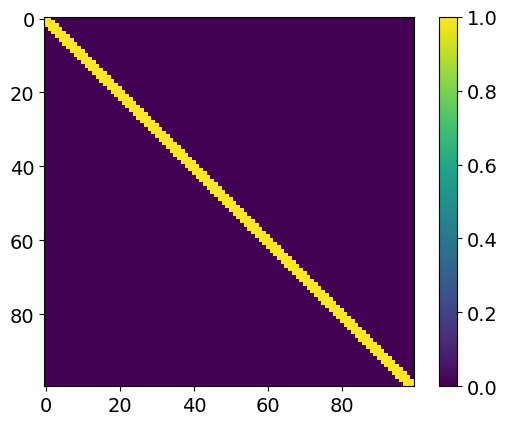

In [23]:
plt.imshow(ratings)
plt.colorbar()

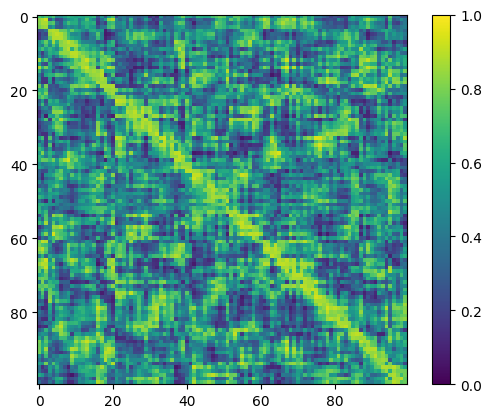

In [216]:
all_users, all_items = [torch.LongTensor(elt) for elt in cart_prod(np.arange(n_users), np.arange(n_items))]

y_pred = model(all_users, all_items).detach().numpy().reshape(n_users, n_items)

plt.imshow(y_pred)
plt.colorbar()
plt.clim(0,1)

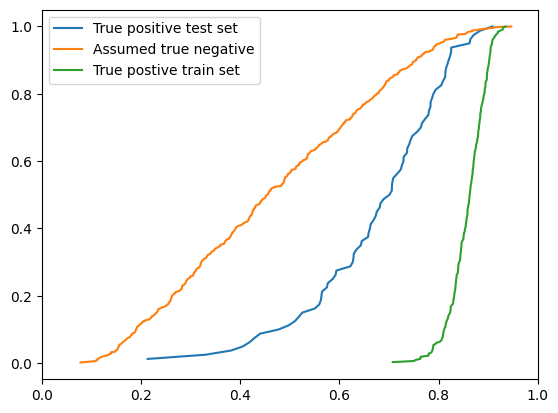

In [221]:
test_prediction = model(test_row, test_col).detach().numpy() # Final prediction
train_prediction = model(obs_rows_train, obs_cols_train).detach().numpy()

# Sample subset of unobserved pairs
n_unobs = 500
unobs_pairs = negative_sample_bipartite(n_unobs, n_users, n_items, obs_pairs, seed=5678)

unobs_pairs = torch.LongTensor(unobs_pairs)
tn_pred = model(unobs_pairs[:,0], unobs_pairs[:,1]).detach().numpy()

labels = ["True positive test set", "Assumed true negative", "True postive train set"]
datas = [test_prediction, tn_pred, train_prediction]
for i in range(len(datas)):
    data = datas[i].reshape(-1, )
    xcdf = sorted(data)
    ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
    plt.plot(xcdf, ycdf, label=labels[i])

plt.xlim(0,1)
plt.legend()
plt.show()

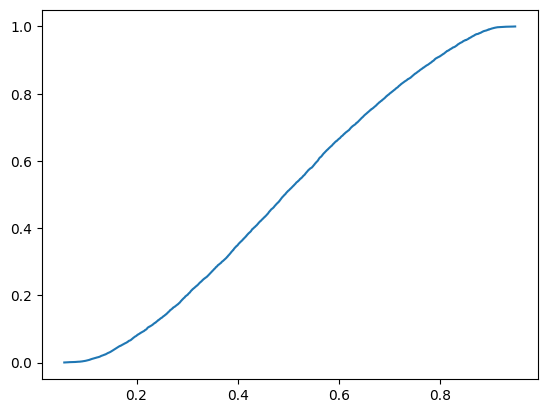

In [218]:
xcdf = sorted(y_pred.reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf)

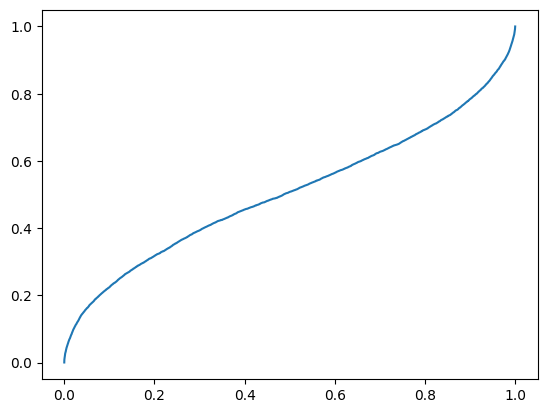

In [219]:
xcdf = sorted(prior_beliefs.reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf)

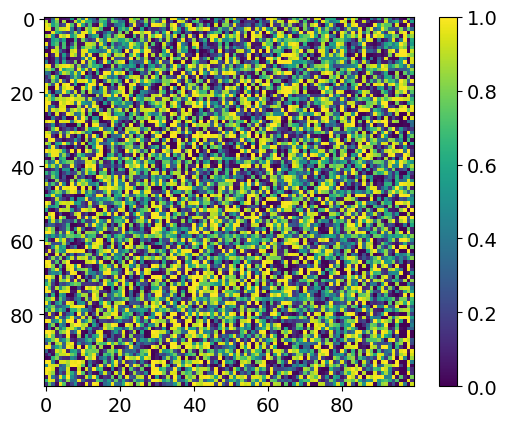

In [22]:
plt.imshow(prior_beliefs)
plt.colorbar()
plt.clim(0,1)
plt.show()

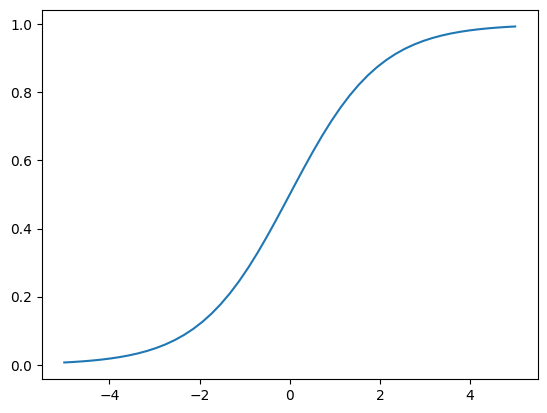

In [787]:
def sigmoid(x, a):
    return 1 / (1 + np.exp(-a * (x)))

a = 1
x = np.linspace(-5, 5)
y = sigmoid(x, a)
plt.plot(x, y)

(-5.0, 5.0)

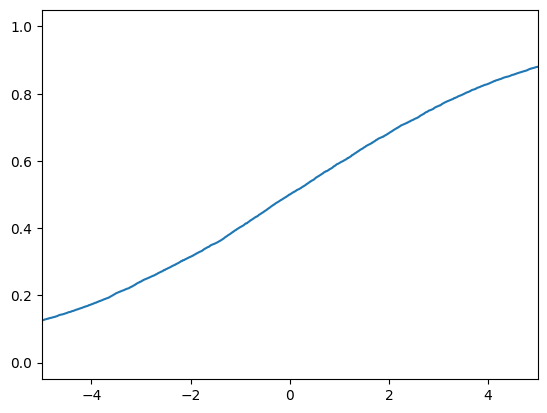

In [189]:
mu = 0
scl = 1e0
n = 100
n_factors = 20

u = rng.normal(loc=mu, scale=scl, size=(n, n_factors))
v = rng.normal(loc=mu, scale=scl, size=(n, n_factors))
cos = (u @ v.T)
xcdf = sorted(cos.reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf)
plt.xlim(-5,5)

(-5.0, 5.0)

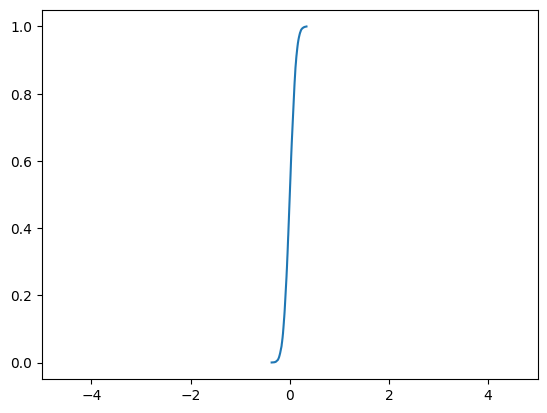

In [44]:
mu = 0
scl = 1e-1
n = 100

u = rng.normal(loc=mu, scale=scl, size=(n*n,))
xcdf = sorted(u.reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf)
plt.xlim(-5,5)

In [204]:
p = np.linspace(0, 1)
q = np.linspace(0, 1)
bce = - p * np.log(q)
bce

/tmp/ipykernel_767/1271682535.py:3: RuntimeWarning: divide by zero encountered in log
  bce = - p * np.log(q)
/tmp/ipykernel_767/1271682535.py:3: RuntimeWarning: invalid value encountered in multiply
  bce = - p * np.log(q)


array([        nan,  0.0794249 ,  0.13055809,  0.17101274,  0.20453273,
        0.23289616,  0.25715031,  0.27798716,  0.29589857,  0.31125228,
        0.32433372,  0.33537092,  0.34455028,  0.35202698,  0.35793228,
        0.3623786 ,  0.36546337,  0.3672718 ,  0.36787906,  0.36735194,
        0.36575021,  0.36312765,  0.35953291,  0.3550102 ,  0.3495999 ,
        0.34333902,  0.33626159,  0.32839903,  0.31978045,  0.31043285,
        0.30038138,  0.28964951,  0.2782592 ,  0.26623103,  0.25358433,
        0.24033731,  0.22650712,  0.21210996,  0.19716117,  0.18167525,
        0.165666  ,  0.14914648,  0.13212915,  0.11462587,  0.09664794,
        0.07820615,  0.05931081,  0.03997177,  0.02019849, -0.        ])

# Recapitulate notebook results w/ skorch framework

In [8]:
from src.mf import MatrixFactorization
from skorch import NeuralNet
import torch
import pickle
from sklearn.model_selection import train_test_split
seed = 1234

In [12]:
with open("../artifacts/trained_models/mf/240424_16_24_27_best_model_knn_neg_multiple_1.pkl", 'rb') as f:
        best_model = pickle.load(f)

X_train, X_test, y_train, y_test = train_test_split(obs_pairs, np.ones(shape=(len(obs_pairs), 1)),
                                                        train_size=0.8,
                                                        shuffle=True,
                                                        random_state=seed)

X_train, X_test = np.array(X_train), np.array(X_test)

n_unobs = 500
unobs_pairs = negative_sample_bipartite(n_unobs, n_users, n_items, obs_pairs, seed=6789)
X_neg = np.array(unobs_pairs)

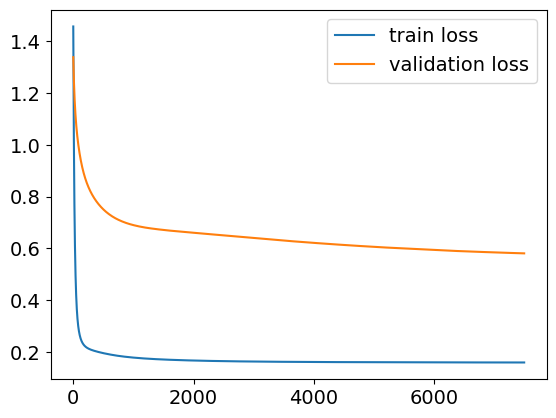

In [13]:
tr_loss, val_loss = list(zip(*best_model.history[:, ('train_loss', 'valid_loss')]))
plt.plot(tr_loss, label="train loss")
plt.plot(val_loss, label="validation loss")
plt.legend()
plt.show()

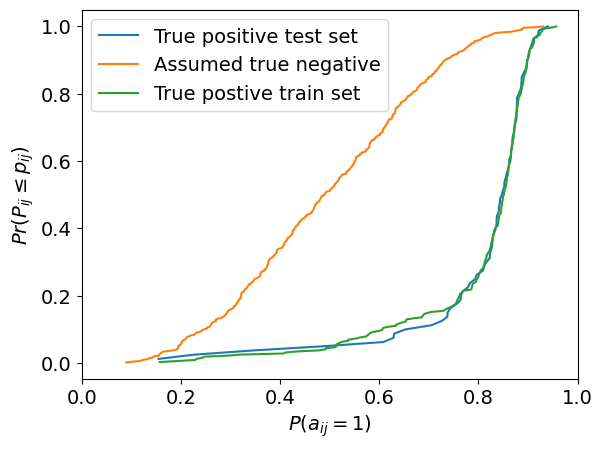

In [14]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

inputs = [X_test, X_neg, X_train]
labels = ["True positive test set", "Assumed true negative", "True postive train set"]
datas = [best_model.predict_proba(elt).reshape(-1, 2)[:,1] for elt in inputs]

for i in range(len(datas)):
    data = datas[i].reshape(-1, )
    xcdf = sorted(data)
    ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
    plt.plot(xcdf, ycdf, label=labels[i])

plt.xlim(0,1)
plt.legend()
plt.xlabel(r"$P(a_{ij} = 1)$")
plt.ylabel(r"$Pr(P_{ij} \leq p_{ij})$")
plt.show()

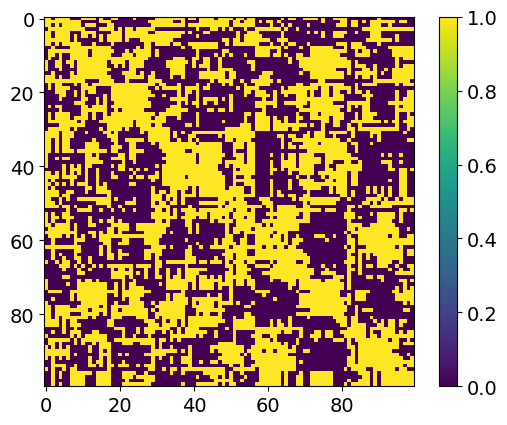

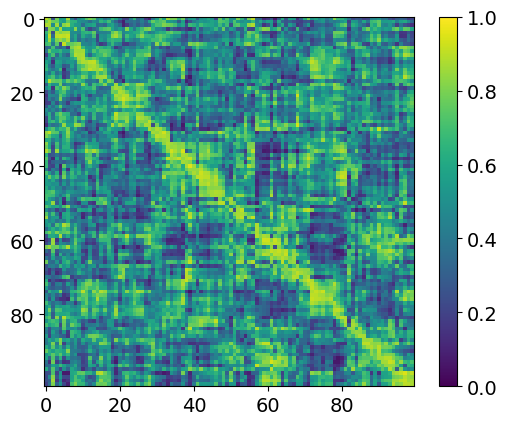

In [7]:
X_full = np.vstack(cart_prod(np.arange(n_users), np.arange(n_items))).T
adj_mat_pred = best_model.predict(X_full).reshape(n_users, n_items)
adj_mat_proba = best_model.predict_proba(X_full)[:, 1, :].reshape(n_users, n_items)
plt.imshow(adj_mat_pred)
plt.colorbar()
plt.clim(0,1)
plt.show()

plt.imshow(adj_mat_proba)
plt.colorbar()
plt.clim(0,1)
plt.show()

In [18]:
import pandas as pd
gs_res = pd.read_csv("artifacts/model_evals/mf/240424_16_24_27_grid_search_knn_neg_multiple_1.csv", sep='\t')
gs_res.sort_values(by=['mean_test_score'], inplace=True, ascending=False)
show_cols = ["mean_fit_time", "param_batch_size", "param_lr", "param_module__n_factors", "param_module__scl_embeds", "param_optimizer__weight_decay", "mean_test_score"]
gs_res.loc[:, show_cols].head(20)

,mean_fit_time,param_batch_size,param_lr,param_module__n_factors,param_module__scl_embeds,param_optimizer__weight_decay,mean_test_score
0,2213.009826,1,0.005,10,False,0.001,-0.630487
2,2170.023211,1,0.005,10,True,0.001,-0.635236
6,233.255013,10,0.005,10,True,0.001,-0.658731
5,235.439417,10,0.005,10,False,0.010,-0.693147
3,2221.609822,1,0.005,10,True,0.010,-0.693147
1,2238.289520,1,0.005,10,False,0.010,-0.693147
7,229.842711,10,0.005,10,True,0.010,-0.693147
4,232.791161,10,0.005,10,False,0.001,-0.746527
